In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets, model_selection, linear_model
from sklearn.metrics import mean_squared_error

<br>

# 1. Preparing dataset (2번부터 실습 진행)

In [2]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data info

- **PassengerId** : Unique ID of passenger
- **Survived** : 0 = No, 1 = Yes
- **pclass** : Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- **sibsp** : # of siblings & spouses aboard the Titanic
- **parch** : # of parents / children aboard the Titanic
- **ticket** : Ticket number
- **cabin** : Cabin number
- **embarked** : Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [3]:
y_data = data_df[['Survived']]
# y_data.head(3)

In [4]:
x_data = data_df.copy()
# x_data.head(3)

<br>

# 2. Feature engineering & Feature selection

#### 시도해볼 수 있는 전략들

- 불필요한 열이나 예측에 방해가 되는 열은 아예 지우기 (ex. PassengerId)
- 결측치 채우기 
- Text로 되어있는 Category(Factor)는 숫자로 바꿔주기 (ex. Male/Female -> 0/1)
- 실수 범위를 구간 범위로 바꿔주기 
- 필요한 경우 기존 열을 바탕으로 새로운 열을 계산해 추가하기

## 1)기본 정보, 요약 통계 보기

In [5]:
x_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
x_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
x_data.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Risien, Mr. Samuel Beard",male,347082,G6,S
freq,1,577,7,4,644


Cabin 또한 200개의 객실 중 147개가 고유값. 따라서 결측치가 없었다 하더라도 큰 의미 없을 듯. Cabin 열 제거해야할 듯

## 2)결측값 확인, 채우기

In [8]:
x_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# 나이

In [10]:
#나이 데이터의 널값 처리를 위한 과정
#클라별로 소득차이가 있을 것이고, 또한 나이에 따라 소득차이도 있을 것이라 추측
#때문에 단순히 나이의 결측치 부분에 전체 평균나이를 넣기보다는 티켓  클라스별로 평균을 구해 이를 입력하였음

In [11]:
# x_data['Age'].loc[x_data['Pclass'] == 1].mean()

In [12]:
# x_data['Age'].loc[x_data['Pclass'] == 2].mean()

In [13]:
# x_data['Age'].loc[x_data['Pclass'] == 3].mean()

In [14]:
# x_data.loc[(x_data['Pclass'] == 1) & (x_data['Age'].isnull()), 'Age'] = 38
# x_data.loc[(x_data['Pclass'] == 2) & (x_data['Age'].isnull()), 'Age'] = 30
# x_data.loc[(x_data['Pclass'] == 3) & (x_data['Age'].isnull()), 'Age'] = 25
# x_data['Age'].isnull().sum()

In [15]:
# 결측치를 중앙값으로 채우기
x_data['Age'].fillna(x_data['Age'].median(), inplace = True)

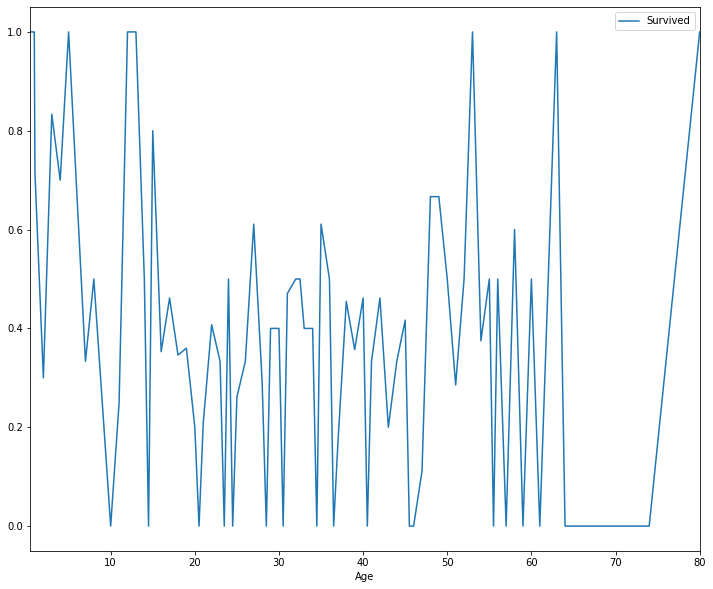

In [16]:
age_piv = pd.pivot_table(data=x_data, index="Age", values="Survived")
age_piv.plot(kind='line', figsize=(12,10))

In [17]:
# Embarked

In [18]:
# 결측치를 최빈값으로 채우기

x_data['Embarked'].fillna(x_data['Embarked'].mode()[0], inplace = True)

In [19]:
x_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [20]:
# cabin은 687개의 결측값이 있다. => 여러 승객이 객실을 공유한 것을 알 수 있다.
# 대부분의 승객이 S 포트 (상단 = S) 승선

In [21]:
x_data.Cabin.value_counts().head()

G6             4
C23 C25 C27    4
B96 B98        4
E101           3
F33            3
Name: Cabin, dtype: int64

## 3)필요없는 열 제거

In [22]:
x_data = x_data.drop(['PassengerId','Ticket'], axis=1)
x_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


## 4) Text로 되어있는 Category(Factor)를 숫자로 바꿔주기

In [23]:
# 성별 (남 : 0. 여 : 1)
# Embarked ('S': 0, 'C': 1, 'Q': 2 )
x_data['Sex'] = x_data['Sex'].apply(lambda x: 1 if x == 'female' else 0 )
x_data['Embarked'] = x_data['Embarked'].apply(lambda x: 0 if x == 'S' else(1 if x == 'C' else 2 ))
x_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,0


## 5) 범주로 나눠서 추가하기

### '가족 수' 열을 만들어서 추가 후 'alone' or 'not alone' 구분
- sibsp : # of siblings & spouses aboard the Titanic
- parch : # of parents / children aboard the Titanic

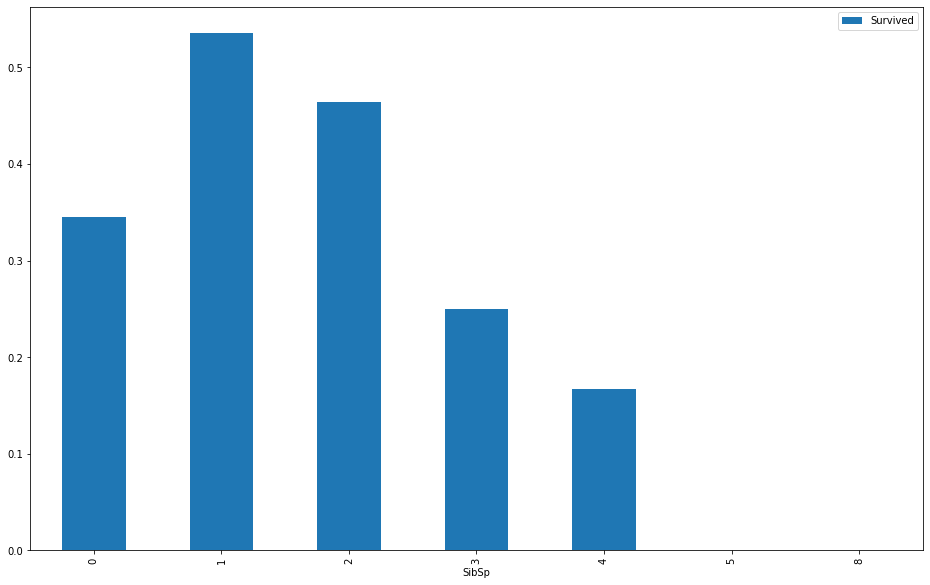

In [24]:
sibsp = pd.pivot_table(data=x_data, index="SibSp", values="Survived")
sibsp.plot(kind='bar', figsize=(16,10 ))

In [25]:
x_data['FamilySize'] = x_data['SibSp'] + x_data['Parch'] + 1
x_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,0,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,1,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,0,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,0,2
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,0,1


In [26]:
# 혼자 탔으면 1, 아니면 0
x_data['Alone'] = x_data['FamilySize'].apply(lambda x: 1 if x == 1 else 0 )
x_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,FamilySize,Alone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,NaN,0,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C85,1,2,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,NaN,0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C123,0,2,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,NaN,0,1,1


In [27]:
x_data = x_data.drop(['SibSp','Parch'], axis=1)

### Fare 범주로 나눠서 추가

In [28]:
# Fare (14이하 : 0, 14~31 : 1, 나머지 : 2)
x_data['Fare'] = x_data['Fare'].apply(lambda x: 0 if x<= 7.91 else(1 if (x > 7.91)&(x <= 14.454) else 2 ))
x_data.head()

,Survived,Pclass,Name,Sex,Age,Fare,Cabin,Embarked,FamilySize,Alone
0,0,3,"Braund, Mr. Owen Harris",0,22.0,0,NaN,0,2,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,2,C85,1,2,0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,1,NaN,0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,2,C123,0,2,0
4,0,3,"Allen, Mr. William Henry",0,35.0,1,NaN,0,1,1


In [29]:
# 결측치를 중앙값으로 채우기
x_data['Fare'].fillna(x_data['Fare'].median(), inplace = True)

### 나이 범주로 나눠서 추가

In [30]:
#'child':미성년자,'youth':청년,'advanced':중년,'prime':장년,'old':노년
bins = [0,15,30,45,60,99]
labels = [0,1,2,3,4]# ['child','youth','advanced','prime','old'] 
cats = pd.cut(x_data.Age, bins, labels=labels)

In [31]:
df1 = pd.DataFrame(x_data[["Age"]], columns=["Age"])
df1["Age_cat"] = pd.cut(x_data.Age, bins, labels=labels)
df1.head()

,Age,Age_cat
0,22.0,1
1,38.0,2
2,26.0,1
3,35.0,2
4,35.0,2


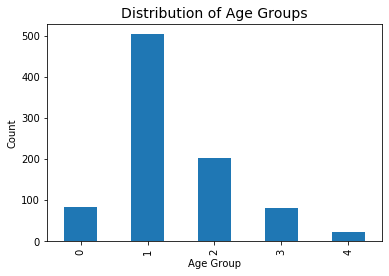

In [32]:
df1.groupby(['Age_cat']).size().plot(kind='bar',stacked=True)
plt.title("Distribution of Age Groups",fontsize=14)
plt.ylabel('Count')
plt.xlabel('Age Group');

In [33]:
x_data["Age_cat"] = df1[["Age_cat"]]
x_data = x_data.drop(['Age'], axis=1)
x_data.head()

,Survived,Pclass,Name,Sex,Fare,Cabin,Embarked,FamilySize,Alone,Age_cat
0,0,3,"Braund, Mr. Owen Harris",0,0,NaN,0,2,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,C85,1,2,0,2
2,1,3,"Heikkinen, Miss. Laina",1,1,NaN,0,1,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,C123,0,2,0,2
4,0,3,"Allen, Mr. William Henry",0,1,NaN,0,1,1,2


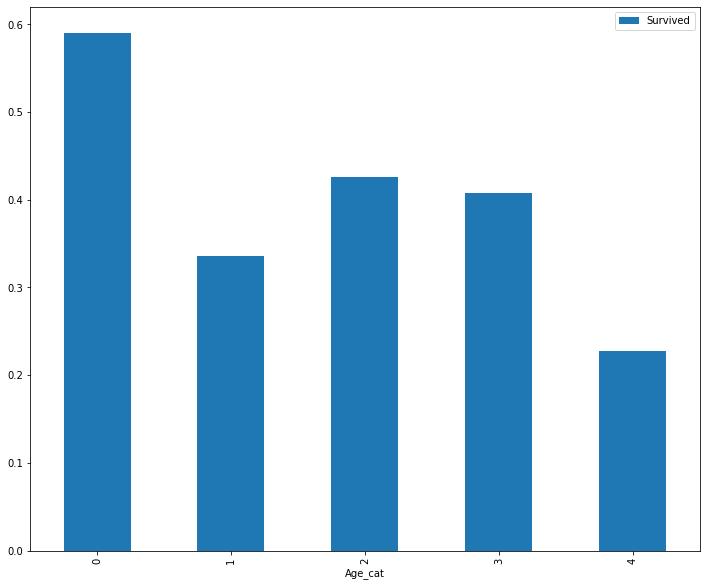

In [34]:
age_cat = pd.pivot_table(data=x_data, index="Age_cat", values="Survived")
age_cat.plot(kind='bar', figsize=(12,10 ))

### 이름 Master, Miss, Mr, Mrs 등만 뽑기 
- Mr : 남자
- Miss : 결혼하지 않은 여성
- Mrs : 결혼한 여성
- Master : 어린 남자아이

In [35]:
# 이름에서 영문, 띄어쓰기만 단어로 뽑기
x_data['Name'] = x_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
# Master, Miss, Mr, Mrs 빼고 나머지는 'Rare'로 만들기
x_data['Name'].replace(['Lady', 'Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
x_data['Name'] = x_data['Name'].replace('Mlle', 'Miss')
x_data['Name'] = x_data['Name'].replace('Ms', 'Miss')
x_data['Name'] = x_data['Name'].replace('Mme', 'Miss')
x_data['Name'] = x_data['Name'].replace('Countess', 'Miss')

In [36]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

x_data['Name'] = x_data['Name'].map(title_mapping).fillna(0).astype('int')

x_data.head()

,Survived,Pclass,Name,Sex,Fare,Cabin,Embarked,FamilySize,Alone,Age_cat
0,0,3,1,0,0,NaN,0,2,0,1
1,1,1,3,1,2,C85,1,2,0,2
2,1,3,2,1,1,NaN,0,1,1,1
3,1,1,3,1,2,C123,0,2,0,2
4,0,3,1,0,1,NaN,0,1,1,2


In [37]:
x_data.loc[(x_data['Name'] == 4) & (x_data['Age_cat'] >= 2)]

,Survived,Pclass,Name,Sex,Fare,Cabin,Embarked,FamilySize,Alone,Age_cat


In [38]:
x_data.loc[(x_data['Name'] == 4) & (x_data['Age_cat'] < 2)]

,Survived,Pclass,Name,Sex,Fare,Cabin,Embarked,FamilySize,Alone,Age_cat
7,0,3,4,0,2,NaN,0,5,0,0
16,0,3,4,0,2,NaN,2,6,0,0
50,0,3,4,0,2,NaN,0,6,0,0
59,0,3,4,0,2,NaN,0,8,0,0
63,0,3,4,0,2,NaN,0,6,0,0
65,1,3,4,0,2,NaN,1,3,0,1
78,1,2,4,0,2,NaN,0,3,0,0
125,1,3,4,0,1,NaN,1,2,0,0
159,0,3,4,0,2,NaN,0,11,0,1
164,0,3,4,0,2,NaN,0,6,0,0


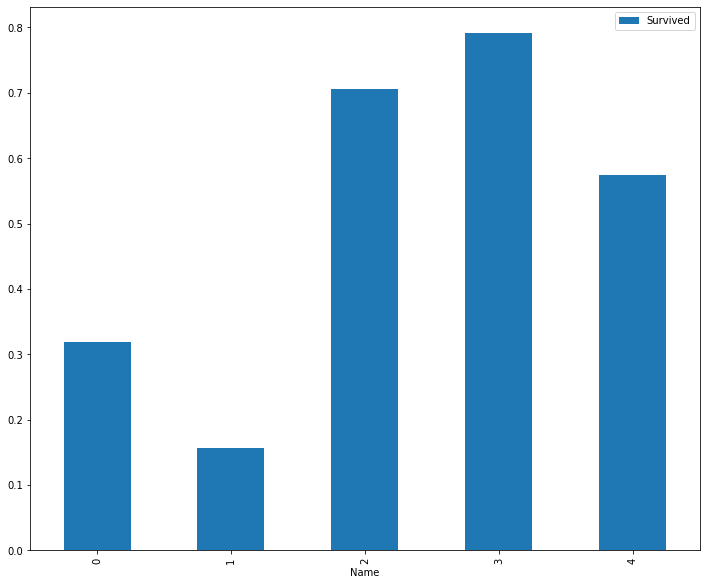

In [39]:
name = pd.pivot_table(data=x_data, index="Name", values="Survived")
name.plot(kind='bar', figsize=(12,10 ))

In [40]:
pd.pivot_table(data=x_data, index="Sex", values="Survived")

,Survived
Sex,
0,0.188908
1,0.742038


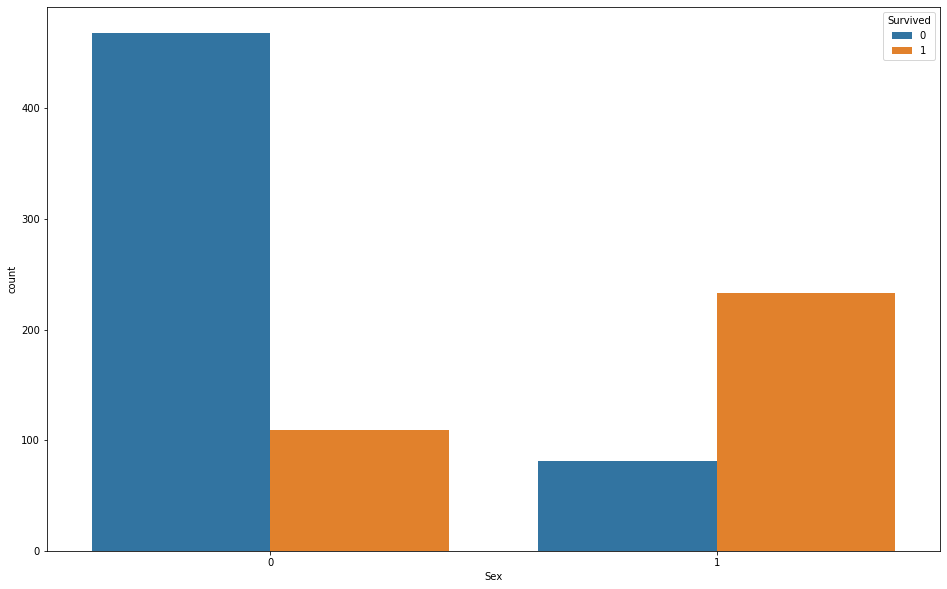

In [41]:
sex_sns = sns.countplot('Sex', hue='Survived', data=x_data)
sex_sns.figure.set_size_inches(16,10)

### Cabin 범주화, 결측값 처리

In [42]:
x_data.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
E101           3
F33            3
              ..
D19            1
B4             1
A31            1
B94            1
C47            1
Name: Cabin, Length: 147, dtype: int64

In [43]:
# 뒤에 숫자까지 분류할 수 없으니 앞에 알파벳만 따서 보기

In [44]:
x_data['Cabin'] = x_data['Cabin'].str[:1]

In [45]:
# pclass와 관련이 있을테니 cabin 결측값의 pclass에서 cabin 값의 평균으로 대체 

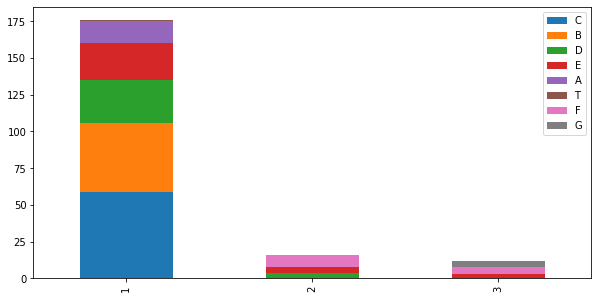

In [46]:
pclass1 = x_data[x_data['Pclass']==1]['Cabin'].value_counts()
pclass2 = x_data[x_data['Pclass']==2]['Cabin'].value_counts()
pclass3 = x_data[x_data['Pclass']==3]['Cabin'].value_counts()
df2 = pd.DataFrame([pclass1,pclass2,pclass3])
df2.index = ['1','2','3']
df2.plot(kind = 'bar',stacked = True, figsize = (10,5))

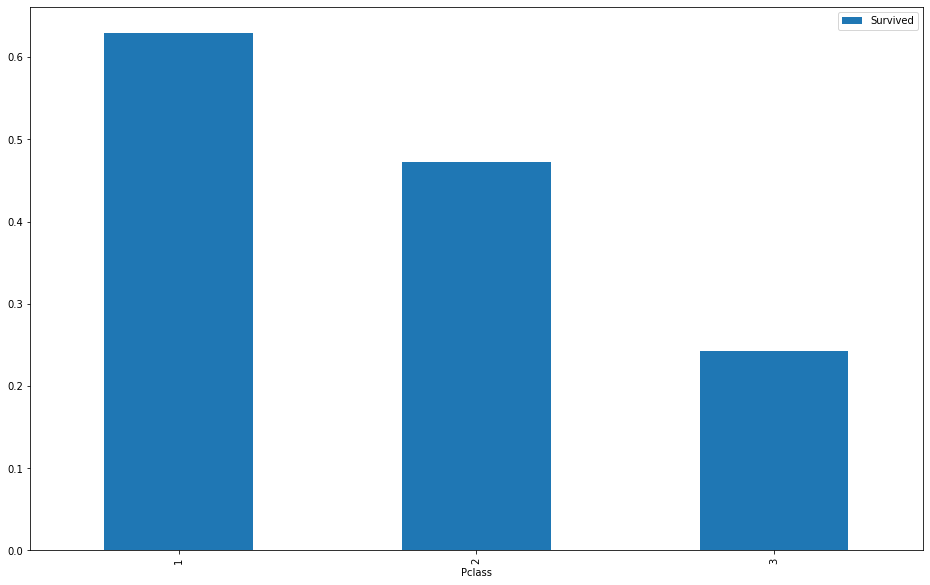

In [47]:
x_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(figsize=(16,10))

In [48]:
# 1등석에는 ABCDE로 시작하는 cabin이 많지만 2,3 등석에는 거의 없음

In [49]:
x_data['Cabin_modi'] = x_data['Cabin']

In [50]:
x_data.loc[x_data['Cabin'].isnull(), 'Cabin_modi'] = 'U'
# x_data.loc[x_data['Cabin'].str.startswithwith('C'), 'Cabin_modi'] = 'C'
x_data['Cabin_modi'].head()

0    U
1    C
2    U
3    C
4    U
Name: Cabin_modi, dtype: object

In [51]:
x_data['Cabin_modi'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [52]:
x_data.loc[x_data['Cabin_modi'].str.startswith('A'), 'Cabin_modi'] = 'A'
x_data.loc[x_data['Cabin_modi'].str.startswith('B'), 'Cabin_modi'] = 'B'
x_data.loc[x_data['Cabin_modi'].str.startswith('C'), 'Cabin_modi'] = 'C'
x_data.loc[x_data['Cabin_modi'].str.startswith('D'), 'Cabin_modi'] = 'D'
x_data.loc[x_data['Cabin_modi'].str.startswith('E'), 'Cabin_modi'] = 'E'
x_data.loc[x_data['Cabin_modi'].str.startswith('F'), 'Cabin_modi'] = 'F'
x_data.loc[x_data['Cabin_modi'].str.startswith('G'), 'Cabin_modi'] = 'G'
x_data.loc[x_data['Cabin_modi'].str.startswith('T'), 'Cabin_modi'] = 'H'

In [53]:
# cabin_mapping = {"A":0,"B":0.4, "C":0.8, "D":1.2, "E":1.6, "F":2, "G":2.4, "T":2.8}

# x_data['Cabin'] = x_data['Cabin'].map(cabin_mapping).fillna(0).astype('int')

In [54]:
# # Pclass의 median으로 Cabin 결측치 대체
# x_data['Cabin'].fillna(x_data.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

In [55]:
x_data = x_data.drop(['FamilySize'], axis=1)

x_data.head()

,Survived,Pclass,Name,Sex,Fare,Cabin,Embarked,Alone,Age_cat,Cabin_modi
0,0,3,1,0,0,NaN,0,0,1,U
1,1,1,3,1,2,C,1,0,2,C
2,1,3,2,1,1,NaN,0,1,1,U
3,1,1,3,1,2,C,0,0,2,C
4,0,3,1,0,1,NaN,0,1,2,U


In [56]:
x_data = x_data.drop(['Cabin'], axis=1)
x_data = x_data.drop(['Survived'], axis=1)
x_data.head()

,Pclass,Name,Sex,Fare,Embarked,Alone,Age_cat,Cabin_modi
0,3,1,0,0,0,0,1,U
1,1,3,1,2,1,0,2,C
2,3,2,1,1,0,1,1,U
3,1,3,1,2,0,0,2,C
4,3,1,0,1,0,1,2,U


In [57]:
# One-hot-encoding for categorical variables
x_data = pd.get_dummies(x_data)

In [58]:
x_data

,Pclass,Name,Sex,Fare,Embarked,Alone,Age_cat,Cabin_modi_A,Cabin_modi_B,Cabin_modi_C,Cabin_modi_D,Cabin_modi_E,Cabin_modi_F,Cabin_modi_G,Cabin_modi_H,Cabin_modi_U
0,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,3,1,2,1,0,2,0,0,1,0,0,0,0,0,0
2,3,2,1,1,0,1,1,0,0,0,0,0,0,0,0,1
3,1,3,1,2,0,0,2,0,0,1,0,0,0,0,0,0
4,3,1,0,1,0,1,2,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1
887,1,2,1,2,0,1,1,0,1,0,0,0,0,0,0,0
888,3,2,1,2,0,0,1,0,0,0,0,0,0,0,0,1
889,1,1,0,2,1,1,1,0,0,1,0,0,0,0,0,0


<br>

## 2. Train - Test split (비율을 7:3 으로 유지해주시고, seed는 0을 적용해주세요)

In [59]:
titanic_data = np.array(x_data)
titanic_target = np.array(y_data)

In [60]:
titanic_target

array([[0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
    

In [61]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(titanic_data, titanic_target, test_size=0.3, random_state=0)

In [62]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(623, 16)
(268, 16)
(623, 1)
(268, 1)


In [63]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [64]:
# Support Vector Machines

svc = SVC()
svc.fit(x_train, y_train)
Y_pred = svc.predict(x_test) 
# pred_test = svc.predict_proba(x_test, probability=True)
acc_svc = round(svc.score(x_train, y_train) * 100, 2)
acc_svc

82.83

In [65]:
from sklearn import metrics

acc_svc = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_svc

80.22

In [66]:
# knn

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train)
Y_pred = knn.predict(x_test)
# pred_test = knn.predict_proba(x_test)
acc_knn = round(knn.score(x_train, y_train) * 100, 2)
acc_knn

86.36

In [67]:
from sklearn import metrics

acc_knn = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_knn

79.85

In [68]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
# pred_test = gaussian.predict_proba(x_test)
acc_gaussian = round(gaussian.score(x_train, y_train) * 100, 2)
acc_gaussian

61.16

In [69]:
from sklearn import metrics

acc_gaussian = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_gaussian

63.06

In [70]:
# Logistic Regression

logistic = linear_model.LogisticRegression()
logistic.fit(x_train, y_train)
Y_pred = logistic.predict(x_test)
pred_test = logistic.predict_proba(x_test)
acc_log = round(logistic.score(x_train, y_train) * 100, 2)
acc_log

83.15

In [71]:
from sklearn import metrics

acc_log = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_log

82.09

In [72]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
acc_linear_svc = round(linear_svc.score(x_train, y_train) * 100, 2)
acc_linear_svc

82.34

In [73]:
from sklearn import metrics

acc_linear_svc = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_linear_svc

79.1

In [74]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
pred_test = logistic.predict_proba(x_test)
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
acc_decision_tree

89.41

In [75]:
from sklearn import metrics

acc_decision_tree = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_decision_tree

82.46

In [76]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
pred_test = logistic.predict_proba(x_test)
#random_forest.score(x_train, y_train)
acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
acc_random_forest

89.41

In [77]:
from sklearn import metrics

acc_random_forest = round(metrics.accuracy_score(Y_pred, y_test) * 100, 2)
acc_random_forest

84.33

In [78]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_test[:,1]) # real y & predicted y (based on "Sepal width")
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)
roc_auc

0.8706249999999999

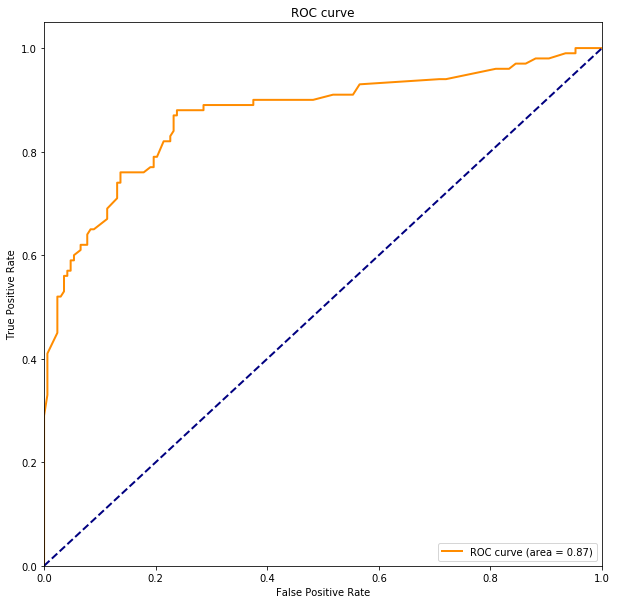

In [79]:
plt.figure(figsize=(10, 10))

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")

plt.show()

In [80]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes',
              'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian,
            acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,84.33
6,Decision Tree,82.46
2,Logistic Regression,82.09
0,Support Vector Machines,80.22
1,KNN,79.85
5,Linear SVC,79.10
4,Naive Bayes,63.06


In [81]:
def train_and_test(model):
    
    model.fit(x_train, y_train)
    
    print('Accuracy: ', accuracy_score(model.predict(x_test), y_test))

In [82]:
# Logistic Regression
log_pred = train_and_test(LogisticRegression())
# SVM+
svm_pred = train_and_test(SVC())
#kNN
knn_pred_4 = train_and_test(KNeighborsClassifier(n_neighbors = 4))
# Random Forest
rf_pred = train_and_test(RandomForestClassifier(n_estimators=100))
# Navie Bayes
nb_pred = train_and_test(GaussianNB())

Accuracy:  0.8208955223880597
Accuracy:  0.8022388059701493
Accuracy:  0.8059701492537313
Accuracy:  0.835820895522388
Accuracy:  0.6305970149253731


In [83]:
# 랜덤포레스트 최적 n_estimators
alist = []
def randomforest(model):
    
    model.fit(x_train, y_train)
    bb=accuracy_score(model.predict(x_test), y_test)
    alist.append(round(bb,4))
    
   

In [84]:
# 가장 좋은 모델에서 최적의 n_estimators 값 찾기
for i in np.arange(1,141,1) : 
    randomforest(RandomForestClassifier(n_estimators=i))
print("max_accuracy :{} ".format(max(alist)))
print('\n')
print("max_accuracy_n_estimators :{}".format(alist.index(max(alist))+1))

max_accuracy :0.8507 


max_accuracy_n_estimators :8
